# CI/CD - Loading and Running a Project (Git) 

In the previous notebooks you saw how to create project function like MLRun jobs and serving functions and how to run a pipeline, this notebooks will demonstrates how to load a project from a Git repository that contain all the project context you created in the development stage, this approach helps you as user to easily run and deploy project context based on your project YAML file.

The project root (context) directory contains the project.yaml file with the required metadata and links to various project functions and artifacts, and is read during the load process.

See also details on loading and using projects with [CI/CD frameworks](https://docs.mlrun.org/en/latest/projects/ci-integration.html). 

Project code, metadata, and configuration are stored and versioned in source control systems like Git or archives (zip, tar) and can be loaded into your work environment or CI system with a single SDK or CLI command.

Tutorial steps:
- [**Work with GIT and archives**](#Git)
- [**Load a Project from Git Repo**](#loadproject)
- [**Runing Functions From Project YAML**](#run)
- [**Deploying a Serving Function From Project YAML**](#deploy)
- [**Build and run automated ML pipelines and CI/CD**](#workflow)


When you use [project.save()](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=project.save()#mlrun.projects.MlrunProject.save) method it stores the project definitions in the `project.yaml`. This allows reconstructing the project in a remote cluster or a CI/CD system. 

<a id="GIT"></a>
## Work with GIT and archives

This notebook uses a git repo that contain the context project, this chapter exapain how can you push your context project to git using MLRun

### Push the project code/metadata into an archive

Use standard git commands to push the current project tree into a git archive. Make sure you `.save()` the project before pushing it, without saving the project your project.yaml file will not include your changes.

    git remote add origin <server>
    git commit -m "Commit message"
    git push origin master

Alternatively, you can use MLRun SDK calls:
- `project.create_remote(git_uri, branch=branch)` &mdash; to register the remote Git path
- `project.push()` &mdash; save the project state and commit/push updates to the remote git repo
    

## MLRun installation and configuration

Before running this notebook make sure the `mlrun` package is installed (`pip install mlrun`) and that you have configured the access to MLRun service. 

In [1]:
# Install MLRun if not installed, run this only once. Restart the notebook after the install!
%pip install mlrun==<server version>

In [2]:
import mlrun

<a id="loadproject"></a>
## Load a Project from Git Repo

When a project is already created and stored in a local dir, git, or archive, you can quickly load a project using the [load_project()](https://docs.mlrun.org/en/latest/api/mlrun.projects.html#mlrun.projects.load_project) method. load_project uses a local context directory (with initialized git) or clones a remote repo into the local dir and returns a project object.

You need to provide the path to the context dir and the git/zip/tar archive url. The name of the project can be specified or taken from the project object. The project can also specify secrets (dict with repo credentials), init_git flag (initializes Git in the context dir), clone flag (project is cloned into the context dir, and the local copy is ignored/deleted), and user_project flag (indicates the project name is unique to the user).
````
# Load the project and run the 'main' workflow.
# When using git as the url source the context directory must be an empty or
# non-existent folder as the git repo will be cloned there
project = load_project("./demo_proj", "git://github.com/mlrun/project-demo.git")
project.run("main", arguments={'data': data_url})
````

In [3]:
# Setting Git source to the Git repo that contain the project.yaml and all other necessary files
git_source = 'git://github.com/GiladShapira94/CI-CD.git'

In [4]:
#Load the project from the Git URL, specified by a new name (ci-cd-load).
#Clone = True means that every time you loas a project MLRun clone the files and overwrite the execting files 
project = mlrun.load_project(name='ci-cd-load',context='./clone',url = git_source,clone=True,init_git=True)

You can see below the project YAML you loaded, in this project we have two jobs funcitons (data-prep and trainer) and one serving function and a workflow named main

In [5]:
print(project.to_yaml())

kind: project
metadata:
  name: ci-cd-load
  created: '2022-09-18T08:50:05.381000'
spec:
  functions:
  - url: data-prep.py
    name: data-prep
    kind: job
    image: mlrun/mlrun
    handler: breast_cancer_generator
  - url: trainer.py
    name: trainer
    kind: job
    image: mlrun/mlrun
    handler: train
  - url: serving.yaml
    name: serving
  workflows:
  - path: workflow.py
    name: main
  artifacts: []
  source: git://github.com/GiladShapira94/CI-CD.git
  origin_url: git://github.com/GiladShapira94/CI-CD.git
  desired_state: online
  owner: shapira
status:
  state: online



<a id="run"></a>
## Run a Fucntion

Use the [run_function()](https://docs.mlrun.org/en/latest/api/mlrun.projects.html#mlrun.projects.run_function) method to run a local or remote batch/scheduled task. The run_function method accepts various parameters such as name, handler, params, inputs, schedule, etc.

The run_function() command returns an MLRun RunObject object that you can use to track the job and its results. If you pass the parameter watch=True (default), the command blocks until the job completes.

#### Load source on runtime 
During the development phase it may be desired to retrieve the code in runtime, rather than re-build the function image every time the code changes. To enable this, use set_source() which gets a path to the source (can be a git repository or a tar or zip file) and set pull_at_runtime=True.

For example:
````
archive_url = "https://s3.us-east-1.wasabisys.com/iguazio/project-archive/project-archive.zip"
project.set_source(source=archive_url, pull_at_runtime=True)

fn = project.set_function(
    name="nuclio", handler="nuclio_func:nuclio_handler",
    image="mlrun/mlrun", kind="nuclio", with_repo=True,
)
````

#### With Repo Attributes
When using with_repo, the contents of the Git repo or archive are available in the current working directory of your MLRun function during runtime.the function needs to be deployed using 
{py:func}`~mlrun.projects.MlrunProject.deploy_function()` or `~mlrun.projects.MlrunProject.build_function` to build a container. Alternatively, you can use 
{py:func}`~mlrun.projects.MlrunProject.set_source()` with `pull_at_runtime=True` which instructs MLRun to load the 
git/archive repo into the function container at run time and therefore does not require a build (this is simpler when 
developing, although for production it's preferred to build the image with the code.)

In [6]:
data_prep_run = project.run_function('data-prep')

> 2022-11-22 12:38:26,425 [info] starting run data-prep-breast_cancer_generator uid=222d78bb847c4ed7a306ef4b03b990f8 DB=http://mlrun-api:8080
> 2022-11-22 12:38:46,770 [info] Job is running in the background, pod: data-prep-breast-cancer-generator-rccjq
> 2022-11-22 12:38:52,690 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ci-cd-load,...03b990f8,0,Nov 22 12:38:50,completed,data-prep-breast_cancer_generator,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.1.2-rc2host=data-prep-breast-cancer-generator-rccjq,,,label_column=label,dataset


> 2022-11-22 12:38:53,235 [info] run executed, status=completed


In [7]:
#Data Prep function outputs
data_prep_run.outputs

{'label_column': 'label',
 'dataset': 'store://artifacts/ci-cd-load/data-prep-breast_cancer_generator_dataset:222d78bb847c4ed7a306ef4b03b990f8'}

In [8]:
#Data Prep dataset
data_prep_run.artifact('dataset').as_df()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [9]:
trainer_run = project.run_function('trainer',
        inputs={"dataset": data_prep_run.outputs["dataset"]},
        params = {
            "model_class": "sklearn.ensemble.RandomForestClassifier",
            "train_test_split_size": 0.2,
            "label_columns": "label",
            "model_name":'breast-cancer-demo'})

> 2022-11-22 12:38:53,711 [info] starting run trainer-train uid=e4f57bb1c7dc48edb69c54670ea99fbe DB=http://mlrun-api:8080
> 2022-11-22 12:38:54,010 [info] Job is running in the background, pod: trainer-train-47brj
> 2022-11-22 12:39:02,276 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ci-cd-load,...0ea99fbe,0,Nov 22 12:38:57,completed,trainer-train,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.1.2-rc2host=trainer-train-47brj,dataset,model_class=sklearn.ensemble.RandomForestClassifiertrain_test_split_size=0.2label_columns=labelmodel_name=breast-cancer-demo,accuracy=0.956140350877193f1_score=0.965034965034965precision_score=0.9583333333333334recall_score=0.971830985915493,feature-importancetest_setconfusion-matrixroc-curvescalibration-curvemodel


> 2022-11-22 12:39:03,629 [info] run executed, status=completed


In [10]:
#Trainer function outputs
trainer_run.outputs

{'accuracy': 0.956140350877193,
 'f1_score': 0.965034965034965,
 'precision_score': 0.9583333333333334,
 'recall_score': 0.971830985915493,
 'feature-importance': 'v3io:///projects/ci-cd-load/artifacts/trainer-train/0/feature-importance.html',
 'test_set': 'store://artifacts/ci-cd-load/trainer-train_test_set:e4f57bb1c7dc48edb69c54670ea99fbe',
 'confusion-matrix': 'v3io:///projects/ci-cd-load/artifacts/trainer-train/0/confusion-matrix.html',
 'roc-curves': 'v3io:///projects/ci-cd-load/artifacts/trainer-train/0/roc-curves.html',
 'calibration-curve': 'v3io:///projects/ci-cd-load/artifacts/trainer-train/0/calibration-curve.html',
 'model': 'store://artifacts/ci-cd-load/breast-cancer-demo:e4f57bb1c7dc48edb69c54670ea99fbe'}

Now after we run our prep data and training functions and created a model file as you saw in the previus notebooks we can deploying our serving function with our new model file

<a id="deploy"></a>
## Deploy a Function

The [deploy_function()](https://docs.mlrun.org/en/latest/api/mlrun.projects.html#mlrun.projects.deploy_function) method is used to deploy real-time/online (nuclio or serving) functions and pipelines. Read more about [Real-time serving pipelines](https://docs.mlrun.org/en/latest/serving/serving-graph.html).

For Serving functions you need to provide the new model to use, you can use the models attribute to that like the example below 

**Important Note  - We created a new model file so we need to provde the serving graph the new model file attributes, please see below example.**

In [11]:
serving_func = project.deploy_function('serving', models=[
            {
                "key": 'cancer-classifier',
                "model_path": trainer_run.outputs['model'],
                "class_name": 'mlrun.frameworks.sklearn.SklearnModelServer',
            }
        ],)

> 2022-11-22 12:39:03,722 [info] Starting remote function deploy
2022-11-22 12:39:04  (info) Deploying function
2022-11-22 12:39:04  (info) Building
2022-11-22 12:39:04  (info) Staging files and preparing base images
2022-11-22 12:39:05  (info) Building processor image
2022-11-22 12:40:30  (info) Build complete
2022-11-22 12:41:00  (info) Function deploy complete
> 2022-11-22 12:41:00,767 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-ci-cd-load-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['ci-cd-load-serving-ci-cd-load.default-tenant.app.cust-cs-il-3-4-1.iguazio-cd1.com/']}


In [12]:
my_data = {"inputs"
           :[[
               1.371e+01, 2.083e+01, 9.020e+01, 5.779e+02, 1.189e-01, 1.645e-01,
               9.366e-02, 5.985e-02, 2.196e-01, 7.451e-02, 5.835e-01, 1.377e+00,
               3.856e+00, 5.096e+01, 8.805e-03, 3.029e-02, 2.488e-02, 1.448e-02,
               1.486e-02, 5.412e-03, 1.706e+01, 2.814e+01, 1.106e+02, 8.970e+02,
               1.654e-01, 3.682e-01, 2.678e-01, 1.556e-01, 3.196e-01, 1.151e-01]
            ]}

In [13]:
#Invoke serving function
serving_func.function.invoke('/',my_data)

> 2022-11-22 12:41:00,888 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ci-cd-load-serving.default-tenant.svc.cluster.local:8080/'}


{'id': '1f3e66cf-3fb1-4bcc-812b-56c5f69ab2b2',
 'model_name': 'cancer-classifier',
 'outputs': [0]}

<a id="workflow"></a>
## Run a Workflow

Use the [run()](https://docs.mlrun.org/en/latest/api/mlrun.projects.html#mlrun.projects.MlrunProject.run) method to execute workflows. Specify the workflow using its name or workflow_path (path to the workflow file) or workflow_handler (the workflow function handler). You can specify the input arguments for the workflow and can override the system default artifact_path.

Workflows are asynchronous by default. You can set the watch flag to True and the run operation blocks until completion and prints out the workflow progress. Alternatively, you can use .wait_for_completion() on the run object.

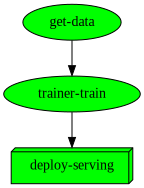

uid,start,state,name,parameters,results
...d93c17bd,Nov 22 12:41:23,completed,trainer-train,model_class=sklearn.ensemble.RandomForestClassifiertrain_test_split_size=0.2label_columns=labelmodel_name=cancer-classifier,accuracy=0.956140350877193f1_score=0.965034965034965precision_score=0.9583333333333334recall_score=0.971830985915493
...1c8c3729,Nov 22 12:41:10,completed,get-data,,label_column=label


a81ad74f-97bf-4af3-80c4-f6359cf4dc70

In [14]:
project.run('main',watch=True)

## Done!